# D.Bài tập

Chọn lấy 1 bộ dữ liệu bất kì từ đây. https://archive.ics.uci.edu/


Chọn lấy ít nhất 3 thuật toán regression tại thư viện Scikit-Learn: https://scikit-learn.org/stable/supervised_learning.html#


So sánh kết quả vẽ hình, đánh giá dựa trên các performance metrics, ví dụ một số metrics tại đây:
https://permetrics.readthedocs.io/en/latest/pages/regression.html

https://github.com/thieu1995/PerMetrics






In [ ]:
5!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)

# data (as pandas dataframes)
X = air_quality.data.features
y = air_quality.data.targets

# metadata
print(air_quality.metadata)

# variable information
print(air_quality.variables)


{'uci_id': 360, 'name': 'Air Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/360/air+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/360/data.csv', 'abstract': 'Contains the responses of a gas multisensor device deployed on the field in an Italian city. Hourly responses averages are recorded along with gas concentrations references from a certified analyzer. ', 'area': 'Computer Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 9358, 'num_features': 15, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C59K5F', 'creators': ['Saverio Vito'], 'intro_paper': {'ID': 420, 'type': 'NATIVE', 'title': 'On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario', 'authors': 

Tên cột sau chuẩn hoá: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Target được dùng: petal_length
X shape: (150, 3) | y shape: (150,)

=== KẾT QUẢ TỔNG HỢP (sắp xếp theo RMSE tăng dần) ===


,MAE,MSE,RMSE,R2,MAPE_%,MedAE,CV_R2_mean,CV_MAE_mean
Model,,,,,,,,
RandomForestRegressor,0.2650,0.1000,0.3162,0.9695,7.67,0.2503,0.9731,0.2171
GradientBoostingRegressor,0.2763,0.1043,0.3229,0.9682,7.87,0.2474,0.9707,0.2305
SVR_rbf,0.2786,0.1291,0.3593,0.9606,7.79,0.2290,0.9673,0.2321
LinearRegression,0.2606,0.1299,0.3604,0.9604,8.73,0.1691,0.9656,0.2444


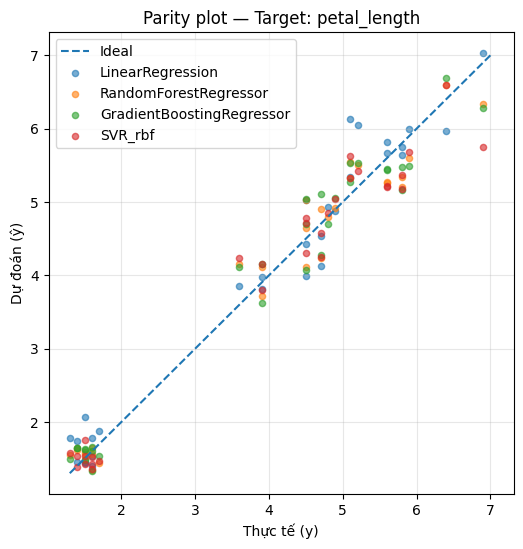

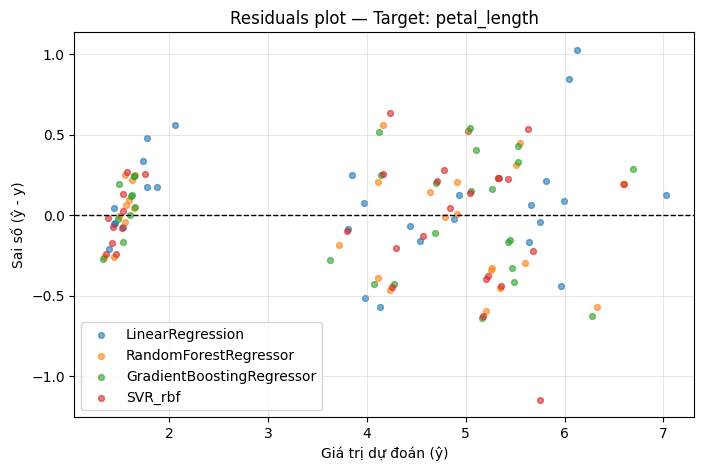

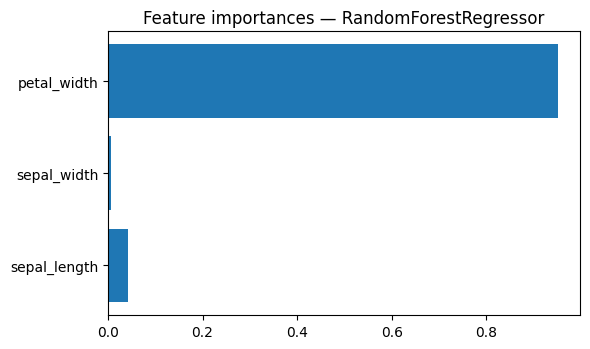

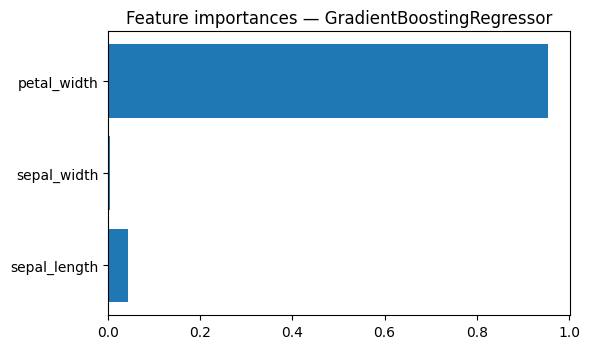

PerMetrics không khả dụng, dùng phép tính nội bộ: cannot import name 'Metrics' from 'permetrics.regression' (/usr/local/lib/python3.12/dist-packages/permetrics/regression.py)

Metrics mở rộng cho model tốt nhất (RandomForestRegressor):


,RandomForestRegressor
NSE,0.969494
KGE,0.960507
PCC,0.984888
R2,0.969494
MAE,0.265036
MSE,0.099979
RMSE,0.316195
MAPE,7.665402
MdAPE,6.017170


In [ ]:

!pip install -q ucimlrepo scikit-learn pandas numpy matplotlib

!pip install -q --upgrade permetrics

# ================== IMPORTS ==================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

RNG = 42
np.random.seed(RNG)
pd.set_option("display.max_colwidth", 200)

# ================== 1) NẠP & CHUẨN HOÁ CỘT ==================
iris = fetch_ucirepo(id=53)

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (out.columns
        .str.strip().str.lower()
        .str.replace(r"\(.*?\)", "", regex=True)      # bỏ (cm)
        .str.replace(r"[^a-z0-9]+", "_", regex=True)  # đổi khoảng trắng/ký tự lạ -> _
        .str.strip("_"))
    return out

X_full = normalize_cols(iris.data.features.copy())
print("Tên cột sau chuẩn hoá:", list(X_full.columns))
# Thường là: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# ================== 2) CHỌN TARGET & TÁCH X, y ==================
TARGET_COL = "petal_length"  # Có thể đổi: 'sepal_length'/'sepal_width'/'petal_width'
if TARGET_COL not in X_full.columns:
    cand = [c for c in X_full.columns if ("petal" in c and "length" in c)]
    TARGET_COL = cand[0] if cand else X_full.select_dtypes(include=[np.number]).columns[-1]

print("Target được dùng:", TARGET_COL)

y = X_full[TARGET_COL].copy()
X = X_full.drop(columns=[TARGET_COL])
print("X shape:", X.shape, "| y shape:", y.shape)

# ================== 3) CHIA TẬP ==================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

# ================== 4) TIỀN XỬ LÝ ==================
num_cols = X_train.columns.tolist()
pre_base = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols)
])
pre_scaled = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols)
])

# ================== 5) ≥3 MÔ HÌNH ==================
models = {
    "LinearRegression": Pipeline([("pre", pre_base), ("model", LinearRegression())]),
    "RandomForestRegressor": Pipeline([("pre", pre_base), ("model", RandomForestRegressor(
        n_estimators=400, random_state=RNG, n_jobs=-1))]),
    "GradientBoostingRegressor": Pipeline([("pre", pre_base), ("model", GradientBoostingRegressor(random_state=RNG))]),
    # Bonus: SVR dùng chuẩn hoá
    "SVR_rbf": Pipeline([("pre", pre_scaled), ("model", SVR(kernel="rbf", C=10.0, epsilon=0.1))])
}

# ================== 6) HÀM TÍNH METRICS CƠ BẢN ==================
def eval_regression(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100
    medae = median_absolute_error(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "MAPE_%": mape, "MedAE": medae}

# ================== 7) HUẤN LUYỆN, DỰ ĐOÁN, 5-FOLD CV ==================
results, preds = [], {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    preds[name] = y_pred

    m = eval_regression(y_test, y_pred)
    m["Model"] = name

    cv = KFold(n_splits=5, shuffle=True, random_state=RNG)
    cv_scores = cross_validate(pipe, X, y, cv=cv,
                               scoring=("r2","neg_mean_absolute_error"),
                               n_jobs=-1, error_score="raise")
    m["CV_R2_mean"]  = float(np.mean(cv_scores["test_r2"]))
    m["CV_MAE_mean"] = float(-np.mean(cv_scores["test_neg_mean_absolute_error"]))
    results.append(m)

df = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
print("\n=== KẾT QUẢ TỔNG HỢP (sắp xếp theo RMSE tăng dần) ===")
try:
    display(df.style.format({
        "MAE":"{:.4f}","MSE":"{:.4f}","RMSE":"{:.4f}","R2":"{:.4f}",
        "MAPE_%":"{:.2f}","MedAE":"{:.4f}","CV_R2_mean":"{:.4f}","CV_MAE_mean":"{:.4f}"
    }))
except:
    print(df)

# ================== 8) VẼ HÌNH ==================
def parity_plot(y_true, pred_dict, max_models=4):
    y_true = np.asarray(y_true)
    plt.figure(figsize=(6,6))
    all_vals = [y_true] + list(pred_dict.values())
    lo = min(map(np.min, all_vals))
    hi = max(map(np.max, all_vals))
    plt.plot([lo, hi], [lo, hi], "--", label="Ideal")
    for i, (name, yp) in enumerate(pred_dict.items()):
        if i >= max_models: break
        plt.scatter(y_true, yp, s=20, alpha=0.6, label=name)
    plt.xlabel("Thực tế (y)"); plt.ylabel("Dự đoán (ŷ)")
    plt.title(f"Parity plot — Target: {TARGET_COL}")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

def residual_plot(y_true, pred_dict, max_models=4):
    y_true = np.asarray(y_true)
    plt.figure(figsize=(8,5))
    for i, (name, yp) in enumerate(pred_dict.items()):
        if i >= max_models: break
        plt.scatter(yp, yp - y_true, s=18, alpha=0.6, label=name)
    plt.axhline(0, color="k", linestyle="--", linewidth=1)
    plt.xlabel("Giá trị dự đoán (ŷ)"); plt.ylabel("Sai số (ŷ - y)")
    plt.title(f"Residuals plot — Target: {TARGET_COL}")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

parity_plot(y_test.values, preds)
residual_plot(y_test.values, preds)

# ================== 9) FEATURE IMPORTANCE (nếu có) ==================
def plot_importance(pipe, name):
    if not hasattr(pipe.named_steps["model"], "feature_importances_"):
        print(f"{name} không hỗ trợ feature_importances_.")
        return
    model = pipe.named_steps["model"]
    importances = model.feature_importances_
    plt.figure(figsize=(6,3.6))
    plt.barh(X.columns, importances)
    plt.title(f"Feature importances — {name}")
    plt.tight_layout(); plt.show()

for n in ["RandomForestRegressor","GradientBoostingRegressor"]:
    if n in models:
        plot_importance(models[n], n)

# ================== 10) METRICS MỞ RỘNG (PerMetrics hoặc FALLBACK) ==================
def extra_metrics_np(y_true, y_pred):
    """Fallback nếu không dùng được permetrics."""
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    # Pearson's r
    r = float(np.corrcoef(y_true, y_pred)[0, 1])
    # R2/MAE/MSE/RMSE/MAPE/MdAPE
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = float(np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100)
    mdape = float(np.median(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100)
    # NSE
    denom = np.sum((y_true - y_true.mean())**2)
    nse = float(1.0 - np.sum((y_pred - y_true)**2) / (denom if denom > 0 else np.nan))
    # KGE
    std_t = np.std(y_true, ddof=1)
    std_p = np.std(y_pred, ddof=1)
    alpha = float(std_p / (std_t if std_t != 0 else np.nan))
    beta  = float(np.mean(y_pred) / (np.mean(y_true) if np.mean(y_true) != 0 else np.nan))
    kge = float(1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2))
    return {
        "NSE": nse, "KGE": kge, "PCC": r, "R2": r2,
        "MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "MdAPE": mdape
    }

best_name = df.index[0]
try:
    from permetrics.regression import Metrics  # Có nơi class này không tồn tại
    met = Metrics(y_test, preds[best_name])
    extra = met.get_metrics_by_list(["NSE","KGE","PCC","R2","MAE","MSE","RMSE","MAPE","MdAPE"])
    df_extra = pd.DataFrame(extra, index=[best_name]).T
except Exception as e:
    print("PerMetrics không khả dụng, dùng phép tính nội bộ:", e)
    df_extra = pd.DataFrame(extra_metrics_np(y_test, preds[best_name]), index=[best_name]).T

print(f"\nMetrics mở rộng cho model tốt nhất ({best_name}):")
try:
    display(df_extra)
except:
    print(df_extra)



